2022-03-02 13:22:52.842078: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/clement/Workspace/oc_p8/env/lib/python3.9/site-packages/cv2/../../lib64:
2022-03-02 13:22:52.842147: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


>>> Error loading model deeplab_v3plus_64 : No file or directory found at ../results/deeplab_v3plus_64/model
>>> Creating new model deeplab_v3plus_64.


2022-03-02 13:22:56.257339: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/clement/Workspace/oc_p8/env/lib/python3.9/site-packages/cv2/../../lib64:
2022-03-02 13:22:56.257363: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-02 13:22:56.257379: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gros-bernard): /proc/driver/nvidia/version does not exist
2022-03-02 13:22:56.257854: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "deeplab_v3plus_64"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 entry_flow_conv1_1 (Conv2D)    (None, 32, 32, 32)   864         ['input_1[0][0]']                
                                                                                                  
 entry_flow_conv1_1_BN (BatchNo  (None, 32, 32, 32)  128         ['entry_flow_conv1_1[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation (Activation)        (None, 32, 32, 32)   0           ['entry_flow_conv

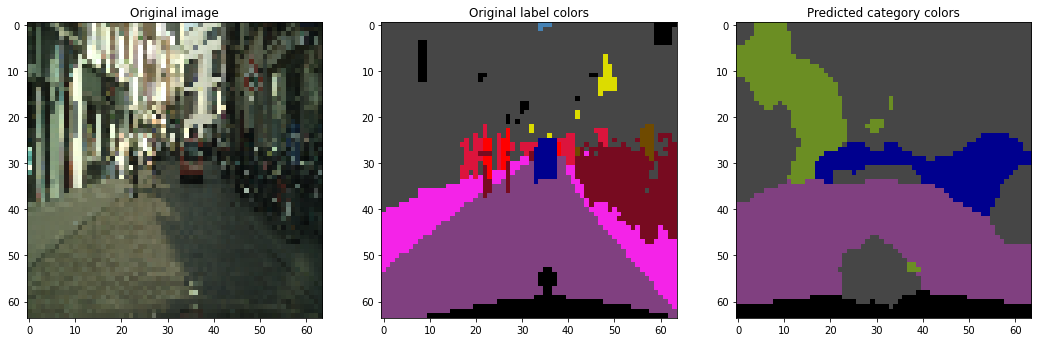

92/92 [==============================] - 625s 7s/step - loss: 0.5472 - MeanIoU: 0.3763 - val_loss: 0.7539 - val_MeanIoU: 0.3520 - lr: 0.0010
Epoch 2/100
92/92 [==============================] - ETA: 0s - loss: 0.3891 - MeanIoU: 0.4748

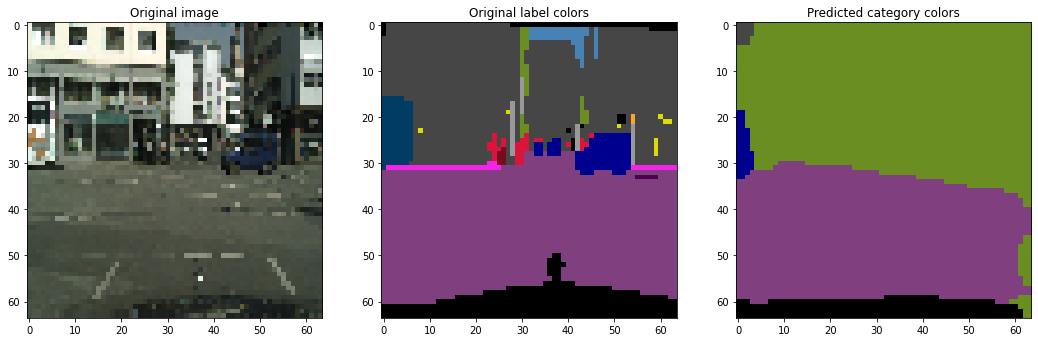

92/92 [==============================] - 566s 6s/step - loss: 0.3891 - MeanIoU: 0.4748 - val_loss: 0.5875 - val_MeanIoU: 0.3551 - lr: 0.0010
Epoch 3/100
92/92 [==============================] - ETA: 0s - loss: 0.3614 - MeanIoU: 0.4920

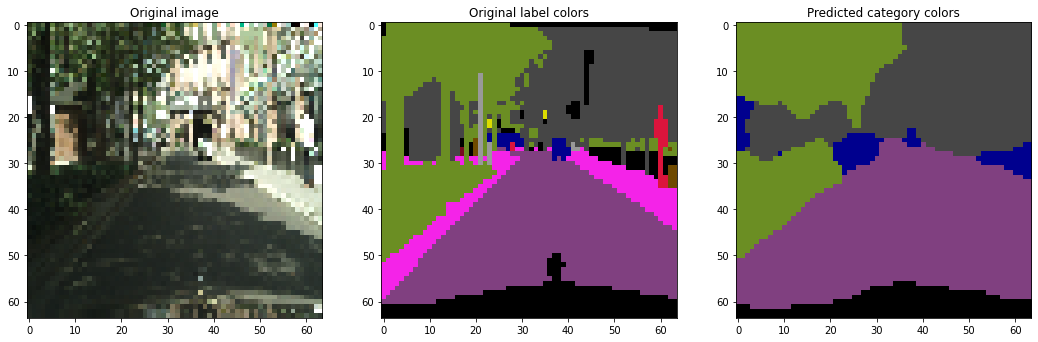

92/92 [==============================] - 581s 6s/step - loss: 0.3614 - MeanIoU: 0.4920 - val_loss: 0.4411 - val_MeanIoU: 0.4364 - lr: 0.0010
Epoch 4/100
92/92 [==============================] - ETA: 0s - loss: 0.3425 - MeanIoU: 0.5047

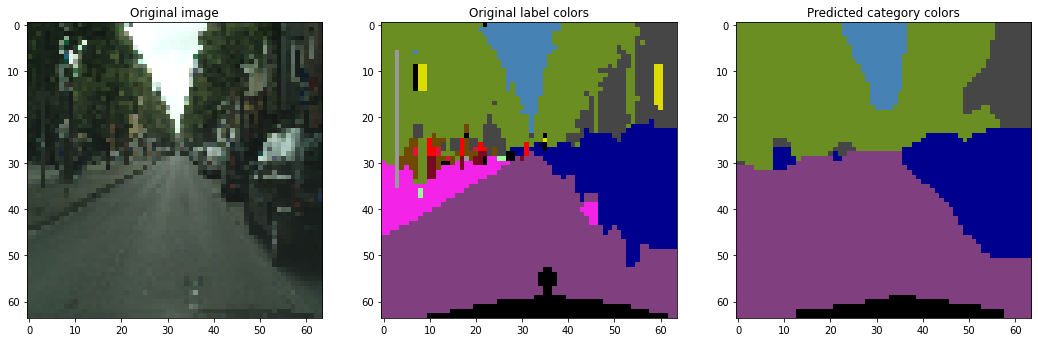

92/92 [==============================] - 599s 6s/step - loss: 0.3425 - MeanIoU: 0.5047 - val_loss: 0.4195 - val_MeanIoU: 0.4479 - lr: 0.0010
Epoch 5/100
92/92 [==============================] - ETA: 0s - loss: 0.3257 - MeanIoU: 0.5156  

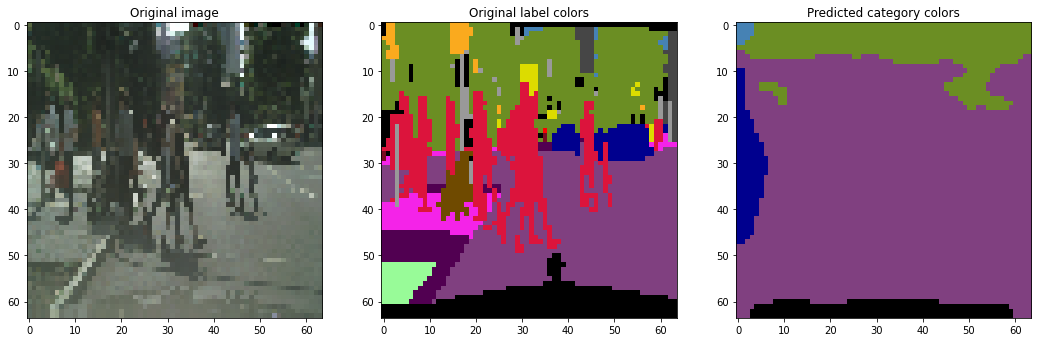

92/92 [==============================] - 7897s 87s/step - loss: 0.3257 - MeanIoU: 0.5156 - val_loss: 0.3937 - val_MeanIoU: 0.4708 - lr: 0.0010
Epoch 6/100
44/92 [=============>................] - ETA: 4:19 - loss: 0.3180 - MeanIoU: 0.5211

In [1]:
import os
import random
from pathlib import Path

import albumentations as aug
import tensorflow as tf

import train.cityscapes as cityscapes
from train.models import deeplab_v3plus, unet_xception


args_model = "deeplab_v3plus"  # "unet_xception"
args_resize = 64
args_batch = 32
args_augment = False


img_size = (args_resize, args_resize)
batch_size = args_batch
num_classes = 8

augment = None
if args_augment:
    # Image augmentation : None for no augmentation
    augment = aug.Compose(
        [
            aug.OneOf(  # Color augmentations
                [
                    aug.RandomBrightnessContrast(),
                    aug.RandomGamma(),
                    aug.RandomToneCurve(),
                ]
            ),
            aug.OneOf(  # Camera augmentations
                [
                    aug.MotionBlur(),
                    aug.GaussNoise(),
                ]
            ),
            aug.OneOf(  # Geometric augmentations
                [
                    aug.HorizontalFlip(),
                    aug.RandomCrop(
                        width=int(img_size[0] / random.uniform(1.0, 2.0)),
                        height=int(img_size[1] / random.uniform(1.0, 2.0)),
                    ),
                    aug.SafeRotate(
                        limit=15,
                    ),
                ]
            ),
            aug.Resize(
                width=img_size[0],
                height=img_size[1],
            ),
        ]
    )

# Get the model
model_name = f"{args_model}_{args_resize}{'_augment' if args_augment else ''}"
model_path = Path("./../results/", model_name)


try:
    model = tf.keras.models.load_model(
        Path(model_path, "model"),
        custom_objects={
            "UpdatedMeanIoU": cityscapes.UpdatedMeanIoU,
            "jaccard_loss": cityscapes.jaccard_loss,
        },
    )
    print(f">>> Loaded model {model_name} .")
except Exception as e:
    print(f">>> Error loading model {model_name} : {e}")
    print(f">>> Creating new model {model_name}.")

    model = None
    if args_model == "unet_xception":
        model = unet_xception.get_model(
            img_size, num_classes, model_name=model_name
        )
    elif args_model == "deeplab_v3plus":
        model = deeplab_v3plus.get_model(
            weights="cityscapes",
            input_tensor=None,
            input_shape=(args_resize, args_resize, 3),
            classes=8,
            backbone="xception", # "mobilenetv2"
            OS=16,
            alpha=1.0,
            activation="softmax",
            model_name=model_name,
        )

model.summary()

# Configure the model for training.
model.compile(
    optimizer="adam",
    loss=cityscapes.jaccard_loss,  # "sparse_categorical_crossentropy",
    metrics=[
        cityscapes.UpdatedMeanIoU(
            name="MeanIoU", num_classes=num_classes
        ),  # https://ilmonteux.github.io/2019/05/10/segmentation-metrics.html
    ],
)

raw_data_path = Path("./../data/raw")
leftImg8bit_path = Path(raw_data_path, "leftImg8bit")
gtFine_path = Path(raw_data_path, "gtFine")

# Train dataset
train_input_img_paths = sorted(
    Path(leftImg8bit_path, "train").glob("**/*_leftImg8bit.png")
)
train_label_ids_img_paths = sorted(
    Path(gtFine_path, "train").glob("**/*_gtFine_labelIds.png")
)

# Validation dataset
val_input_img_paths = sorted(
    Path(leftImg8bit_path, "val").glob("**/*_leftImg8bit.png")
)
val_label_ids_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_gtFine_labelIds.png")
)
val_label_colors_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_color.png")
)


# train model
model.fit(
    cityscapes.CityscapesGenerator(
        batch_size,
        img_size,
        train_input_img_paths,
        train_label_ids_img_paths,
        augment,
    ),
    validation_data=cityscapes.CityscapesGenerator(
        batch_size,
        img_size,
        val_input_img_paths,
        val_label_ids_img_paths,
        augment,
    ),
    epochs=100,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            patience=2,
            factor=0.5,
            min_delta=1e-2,
            min_lr=1e-7,
            verbose=1,
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            restore_best_weights=True,
            min_delta=1e-3,
            verbose=1,
        ),
        tf.keras.callbacks.TensorBoard(log_dir=Path(model_path, "./logs")),
        cityscapes.CityscapesViewerCallback(
            val_input_img_paths, val_label_colors_img_paths, img_size
        ),
    ],
)

# save model
model.save(Path(model_path, "model"))
